In [1]:
import json 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from sedpy import observate

from astropy.cosmology import FlatLambdaCDM

In [2]:
# Load in the basic data
df = pd.read_csv("../data/all_basic_data.csv")

In [5]:
# Load in all of the spectra --> this may take some time
zzzs = [ i for i in range(4,11) ]
zzz1 = zzzs.copy()
zzz1[0] = 4.64
all_spectra = []
for z in zzzs:
    with open(f"../data/spectra/all_spec_z{z}.json") as f:
        dat = json.load(f)
    all_spectra.append(dat)

In [6]:
# Some constants
ndir = 10 # Number of directions from peeling off

lsun = 3.846e33
cosmo = FlatLambdaCDM(H0=67.31, Om0=0.3175, Tcmb0=2.725)
mpc_to_cm = 3.086e+24
clight = 29979245800. #cm/s

In [7]:
# Print a header
df.head(n=10)

,halo_id,redshift,x,y,z,mvir,rvir,n_stars,stellar_mass,sfr_3,...,F277W_int,F300M_int,F335M_int,F356W_int,F360M_int,F410M_int,F430M_int,F444W_int,F460M_int,F480M_int
0,1955,10.0,0.226624,0.216377,0.109282,9.234144,0.001932,31967,7.20,1.31,...,29.884969,29.923696,29.946790,29.949927,29.944244,30.021190,29.977008,29.937638,29.942235,29.804002
1,2721,10.0,0.027271,0.335342,0.987246,9.499563,0.002361,50539,7.43,0.79,...,29.832259,29.877856,29.923394,29.939290,29.940309,29.959567,29.893601,29.896543,29.904001,29.802340
2,10158,10.0,0.296111,0.070418,0.311175,8.990255,0.001602,23168,7.04,0.43,...,30.792247,30.845234,30.891962,30.901009,30.902428,30.849527,30.792212,30.781773,30.766390,30.706044
3,12827,10.0,0.285522,0.432471,0.479433,9.695849,0.002751,116572,7.73,0.19,...,29.615865,29.661411,29.709806,29.725960,29.729763,29.608374,29.497049,29.519798,29.478483,29.444568
4,12907,10.0,0.274319,0.433607,0.452588,8.802573,0.001387,27501,7.11,0.55,...,30.311605,30.355300,30.398376,30.416435,30.416138,30.463976,30.399358,30.410006,30.437904,30.309920
5,14499,10.0,0.161716,0.394084,0.334233,9.429246,0.002244,58050,7.46,0.84,...,30.039922,30.088020,30.133297,30.144423,30.145461,30.173739,30.116714,30.099841,30.080944,30.011600
6,22470,10.0,0.201511,0.995079,0.519205,9.576676,0.002510,84158,7.64,0.35,...,30.098457,30.141799,30.182472,30.190774,30.192114,30.112523,30.035533,30.029949,29.995179,29.949622
7,23759,10.0,0.481061,0.240925,0.600468,10.052344,0.003610,464637,8.39,0.70,...,28.667609,28.698480,28.731172,28.740642,28.742376,28.563895,28.398063,28.435639,28.355822,28.341752
8,29558,10.0,0.170277,0.158444,0.983102,9.461591,0.002293,61656,7.50,0.99,...,29.397090,29.445778,29.493070,29.507610,29.509131,29.495268,29.447801,29.443778,29.454409,29.366637
9,31833,10.0,0.200272,0.487174,0.856606,8.991689,0.001598,39661,7.23,0.57,...,30.442257,30.470856,30.487304,30.494957,30.488144,30.547634,30.425603,30.436878,30.429075,30.279160


## Example intrinsic spectrum at z=6

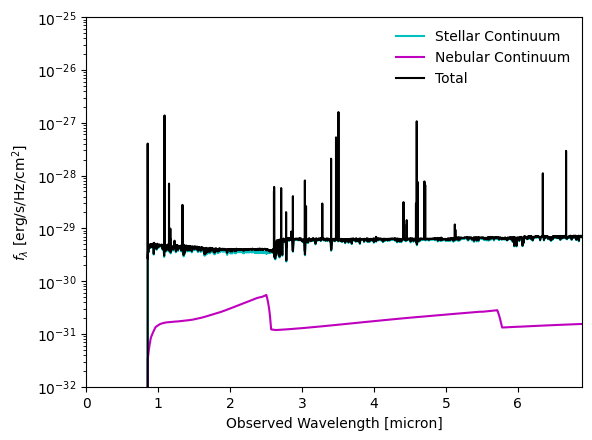

In [18]:
redshift = 6.0
# For a typical galaxy
halo_id = "70405"

# Plot the intrinsic stellar spectrum
plt.plot(
    all_spectra[2]["70405"]["wavelengths"],
    10.**np.array(all_spectra[2]["70405"]["intrinsic"]["stellar_continuum"]),
    c="c",label="Stellar Continuum")

# Plot the intrinsic nebular continuum
plt.plot(
    all_spectra[2]["70405"]["wavelengths"],
    10.**np.array(all_spectra[2]["70405"]["intrinsic"]["nebular_continuum"]),
    c="m",label="Nebular Continuum")

# Sum the nebular continuum, stellar continuum, and emission lines
plt.plot(
    all_spectra[2]["70405"]["wavelengths"],
    10.**np.array(all_spectra[2]["70405"]["intrinsic"]["total"]),
    c="k",label="Total")

plt.yscale("log")
plt.xscale("linear")
plt.ylim(1e-32,1e-25)
plt.xlim(0,6.9)

plt.xlabel("Observed Wavelength [micron]")
plt.ylabel(r"$f_{\lambda}\ {\rm [erg/s/Hz/cm^2]}$")
plt.legend(loc=1,frameon=False)

### Plot the spectra against the JWST filter magnitudes

In [49]:
# List of relevant JWST filters
all_filts = [
 'jwst_f070w',
 'jwst_f090w',
 'jwst_f115w',
 'jwst_f140m',
 'jwst_f150w',
 'jwst_f162m',
 'jwst_f182m',
 'jwst_f200w',
 'jwst_f210m',
 'jwst_f250m',
 'jwst_f277w',
 'jwst_f300m',
 'jwst_f335m',
 'jwst_f356w',
 'jwst_f360m',
 'jwst_f410m',
 'jwst_f430m',
 'jwst_f444w',
 'jwst_f460m',
 'jwst_f480m',
]
wave_dw = np.array([observate.Filter(i).effective_width for i in all_filts])/1e4
wave_w  = np.array([observate.Filter(i).wave_mean for i in all_filts])/1e4

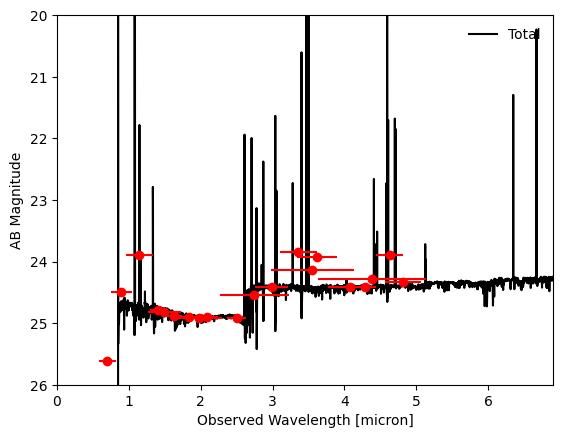

In [53]:
redshift = 6.0
# For a typical galaxy
halo_id = "70405"

# Get the JWST filter magnitudes for the galaxy
all_mags = np.zeros(len(all_filts))
for i,key in enumerate(all_filts):
    jwst_filt = key.split("_")[-1].upper()
    new_key = f"{jwst_filt}_int"
    all_mags[i] = float(df[df["halo_id"]==int(halo_id)][new_key])

# Plot the total intrinsic spectrum 
plt.plot(
    all_spectra[2]["70405"]["wavelengths"],
    -2.5 * np.log10(10.**np.array(all_spectra[2]["70405"]["intrinsic"]["total"])/(1e-23 * 3631.)),
    c="k",label="Total")

# Plot the filter magnitudes
plt.errorbar(wave_w,all_mags,xerr=wave_dw,fmt="o",color="r")

plt.yscale("linear")
plt.xscale("linear")
plt.xlim(0,6.9)
plt.ylim(26,20)
plt.xlabel("Observed Wavelength [micron]")
plt.ylabel("AB Magnitude")
plt.legend(loc=1,frameon=False)

## Example dust attenuated spectrum at z=6

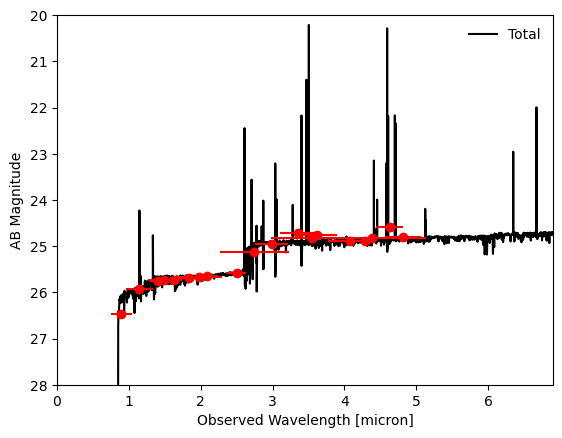

In [58]:
redshift = 6.0
# For a typical galaxy
halo_id = "70405"
direction = 1 # Change this from 0-9 to see other directions


# Get the JWST filter magnitudes for the galaxy
all_mags = np.zeros(len(all_filts))
for i,key in enumerate(all_filts):
    jwst_filt = key.split("_")[-1].upper()
    new_key = f"{jwst_filt}_dir_{direction}"
    all_mags[i] = float(df[df["halo_id"]==int(halo_id)][new_key])

# Plot the total intrinsic spectrum 
plt.plot(
    all_spectra[2]["70405"]["wavelengths"],
    -2.5 * np.log10(10.**np.array(all_spectra[2]["70405"][f"dir_{direction}"]["total"])/(1e-23 * 3631.)),
    c="k",label="Total")

# Plot the filter magnitudes
plt.errorbar(wave_w,all_mags,xerr=wave_dw,fmt="o",color="r")

plt.yscale("linear")
plt.xscale("linear")
plt.xlim(0,6.9)
plt.ylim(28,20)
plt.xlabel("Observed Wavelength [micron]")
plt.ylabel("AB Magnitude")
plt.legend(loc=1,frameon=False)